In [2]:
from dataclasses import dataclass
from enum import StrEnum
from datetime import datetime, timedelta
import polars as pl
from common.constants.column_types import (
    CPZP_SCHEMA,
    OZP_SCHEMA,
    POHLAVI_CPZP,
    TYP_UDALOSTI,
)
from common.constants.column_names import SHARED_COLUMNS, OZP_COLUMNS, CPZP_COLUMNS
import pickle
from common.constants.objects import (
    Person,
    Gender,
    AgeCohort,
    Prescription,
    PrescriptionType,
)
from common.utils import draw_chart

pl.Config.set_tbl_rows(20)
pl.Config.set_tbl_cols(60)


with open("./DATACON_data/cpzp_persons.pkl", "rb") as f:
    cpzp_persons: list[Person] = pickle.load(f)

with open("./DATACON_data/ozp_persons.pkl", "rb") as f:
    ozp_persons: list[Person] = pickle.load(f)

In [20]:
from common.constants.objects import Vaccine


persons = sorted(ozp_persons, key=lambda p: p.id)
dead_persons = [p for p in persons if p.died_at and p.vaccines]

dead_indexes_map = {
    1: {},
    2: {},
    3: {},
    4: {},
    5: {},
    6: {},
    7: {},
}

first_pr_from_first_dose_map = {
    0: {},
    1: {},
    2: {},
    3: {},
    4: {},
    5: {},
    6: {},
    7: {},
    8: {},
}

first_pr_map_no_vax_segregation = {}

first_pr_map_vax_segregation = {
    0: {},
    1: {},
    2: {},
    3: {},
    4: {},
    5: {},
    6: {},
    7: {},
    8: {},
}


for p in dead_persons:
    last_vax_date = p.vaccines[-1].date if p.vaccines else None
    if last_vax_date:
        day_of_death = p.died_at
        # if day_of_death.day == 1:
        #     next_month = (day_of_death.replace(day=28) + timedelta(days=4)).replace(
        #         day=1
        #     )
        #     day_of_death = next_month - timedelta(days=1)

        days_after_last_vax = (day_of_death - last_vax_date).days
        if days_after_last_vax < 0:
            continue
        if days_after_last_vax not in dead_indexes_map[len(p.vaccines)]:
            dead_indexes_map[len(p.vaccines)][days_after_last_vax] = 1
        else:
            dead_indexes_map[len(p.vaccines)][days_after_last_vax] += 1


def find_closest_date(target_date: datetime, dates: list[Vaccine]):
    if not dates:
        return None
    return max(dates, key=lambda d: target_date - d.date)


n_of_imunosuppresives = 0
n_of_corts = 0
for p in persons:
    first_prescription_date = p.prescriptions[0].date if p.prescriptions else None
    first_vax_date = p.vaccines[0].date if p.vaccines else None

    if first_prescription_date and first_vax_date:
        if not p.prescriptions[0].equiv_sloucenina:
            n_of_imunosuppresives += 1
            continue
        else:
            n_of_corts += 1
        closest_vax_date = (
            find_closest_date(first_prescription_date, p.vaccines).date
            if p.vaccines
            else None
        )

        days_after_first_prescription = (first_prescription_date - first_vax_date).days
        # print(first_prescription_date, first_vax_date, days_after_first_prescription)
        if days_after_first_prescription not in first_pr_map_no_vax_segregation:
            first_pr_map_no_vax_segregation[days_after_first_prescription] = 1
        else:
            first_pr_map_no_vax_segregation[days_after_first_prescription] += 1

        if (
            days_after_first_prescription
            not in first_pr_from_first_dose_map[
                len(p.vaccines)
            ]  # kolik má člověk celkově vakcín
        ):
            first_pr_from_first_dose_map[len(p.vaccines)][
                days_after_first_prescription
            ] = 1
        else:
            first_pr_from_first_dose_map[len(p.vaccines)][
                days_after_first_prescription
            ] += 1

        if closest_vax_date:
            days_after_closest_vax = (first_prescription_date - closest_vax_date).days
            if (
                days_after_closest_vax
                not in first_pr_map_vax_segregation[len(p.vaccines)]
            ):
                first_pr_map_vax_segregation[len(p.vaccines)][
                    days_after_closest_vax
                ] = 1
            else:
                first_pr_map_vax_segregation[len(p.vaccines)][
                    days_after_closest_vax
                ] += 1

print(n_of_imunosuppresives)
print(n_of_corts)

4343
198257


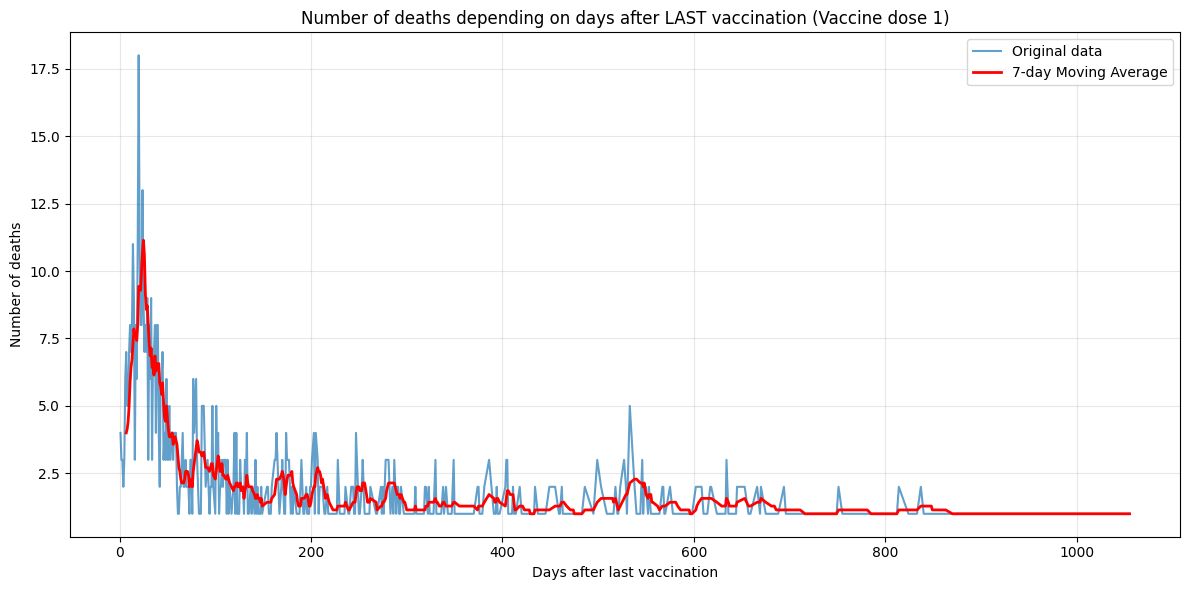

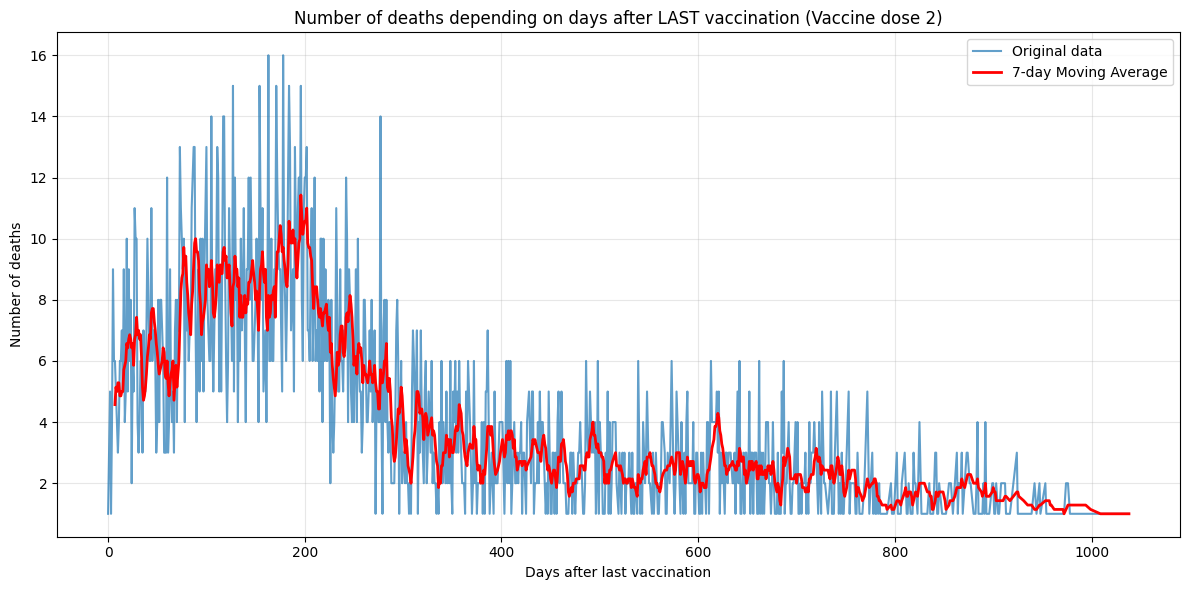

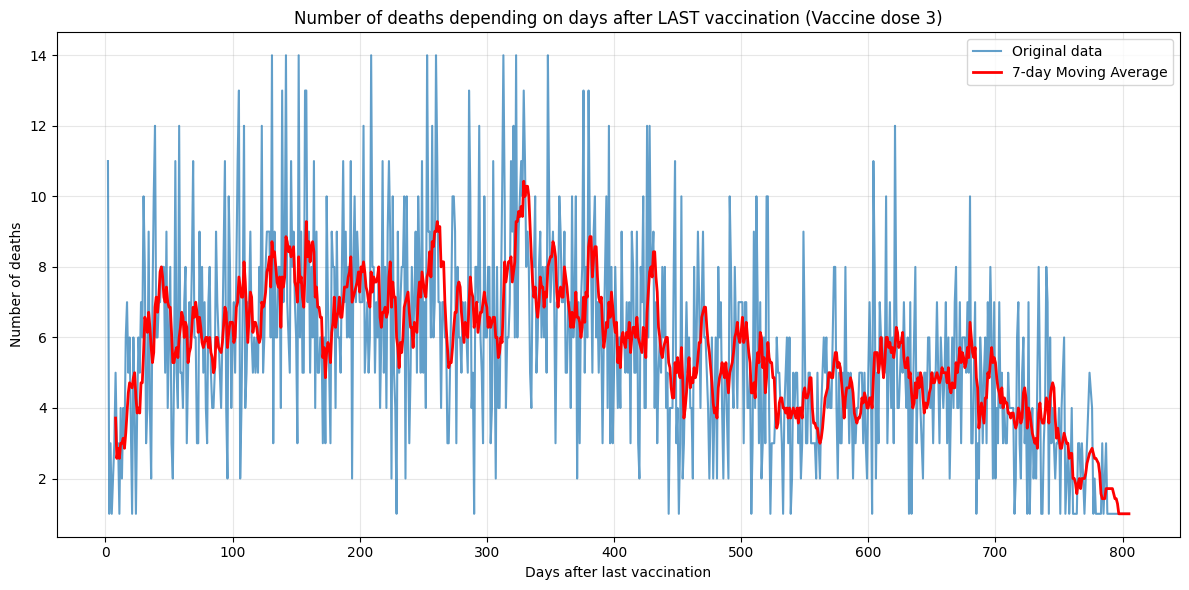

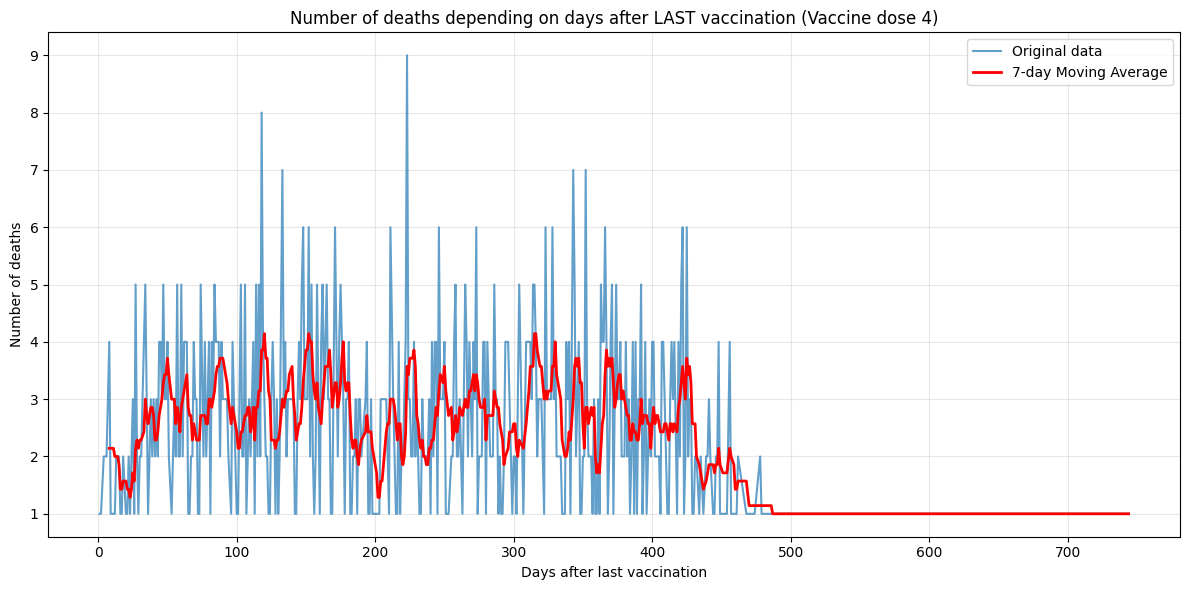

In [21]:
# === HVE per each dose ===
for vaccine_amount, indexes_map in dead_indexes_map.items():
    draw_chart(
        indexes_map,
        "Days after last vaccination",
        "Number of deaths",
        f"Number of deaths depending on days after LAST vaccination (Vaccine dose {vaccine_amount})",
    )

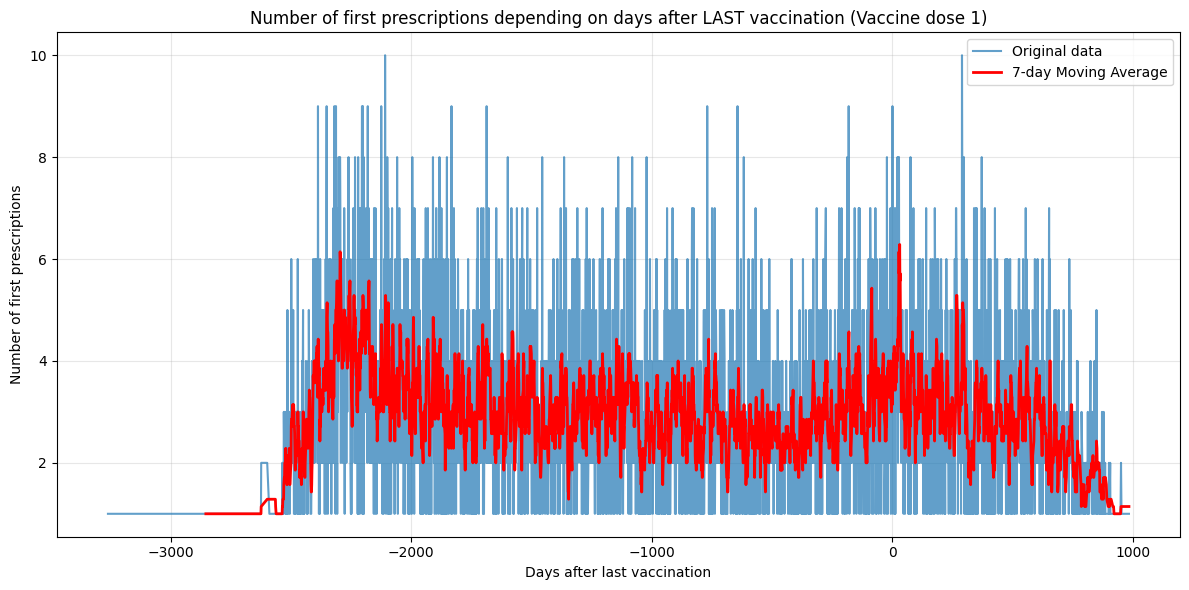

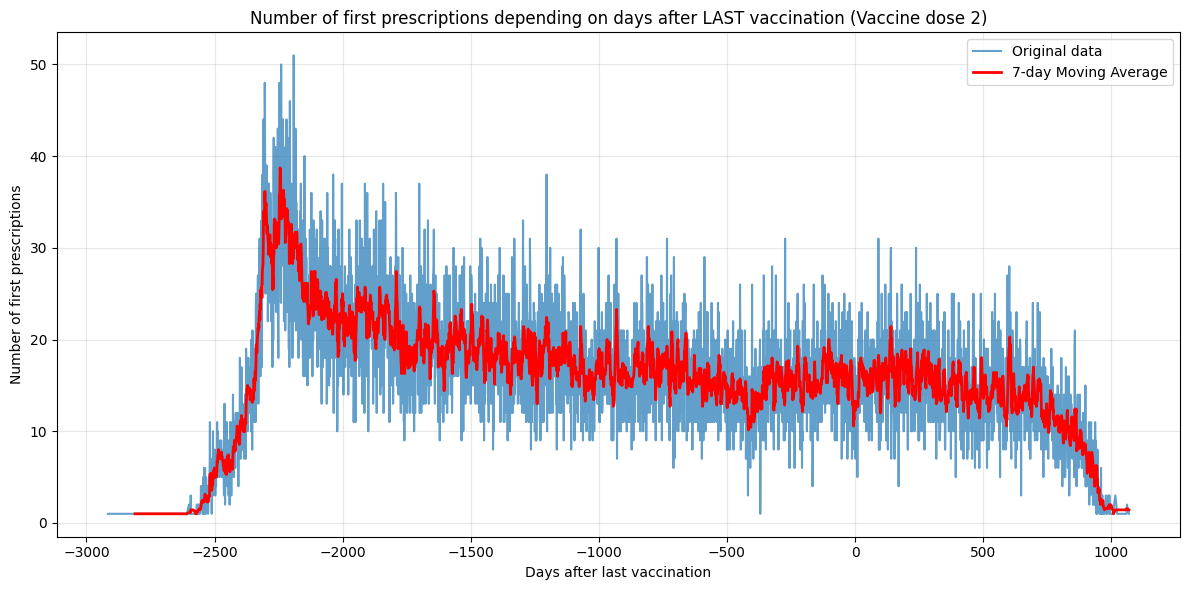

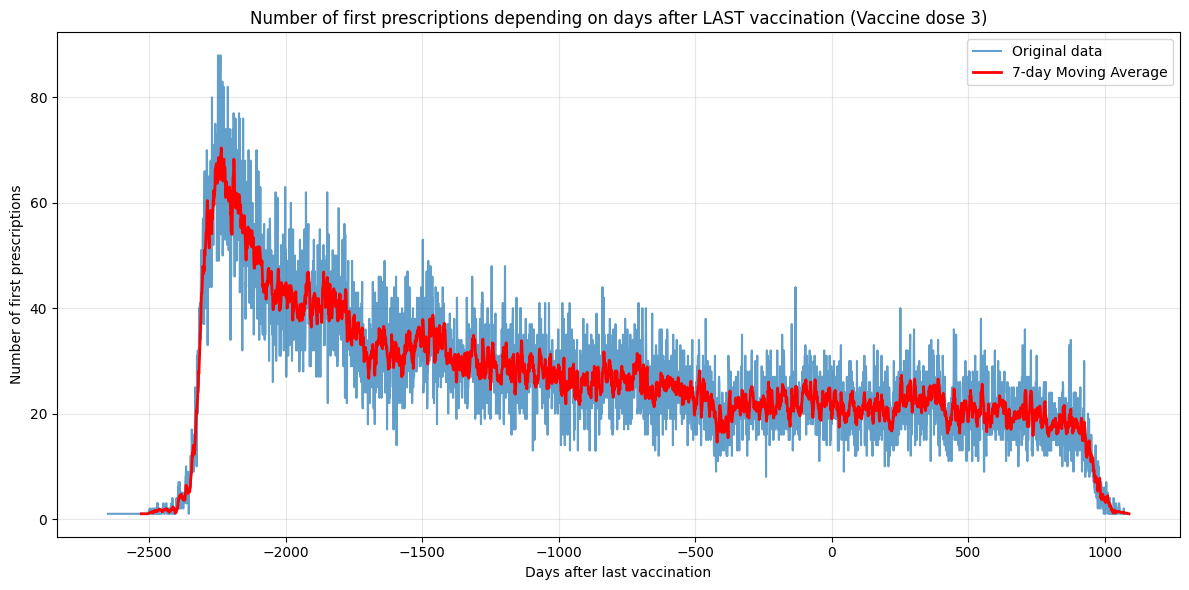

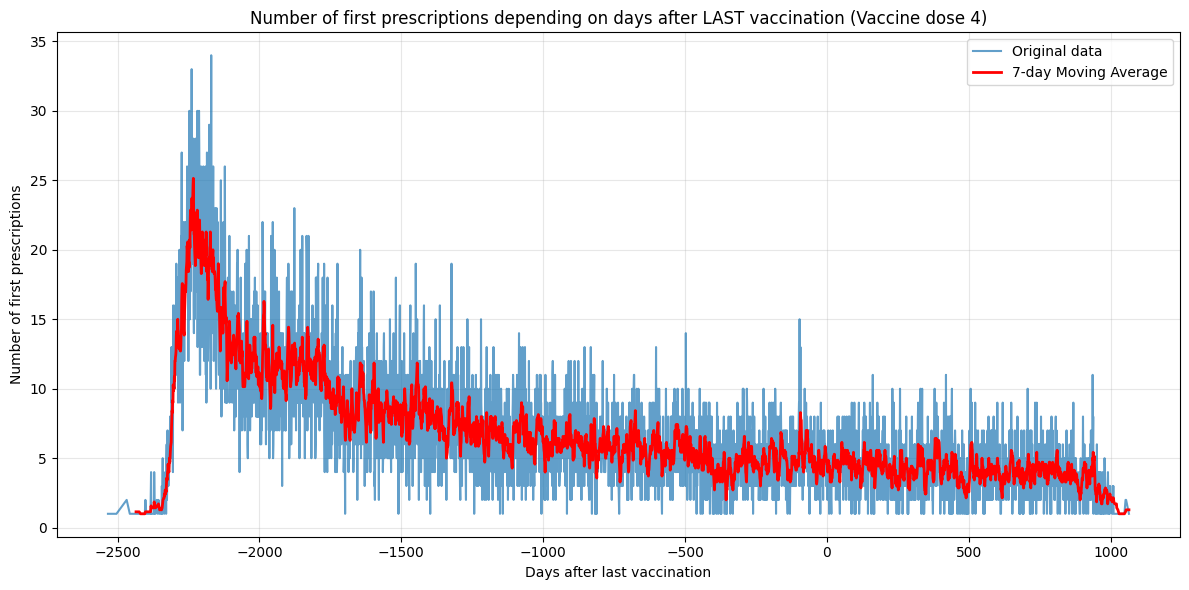

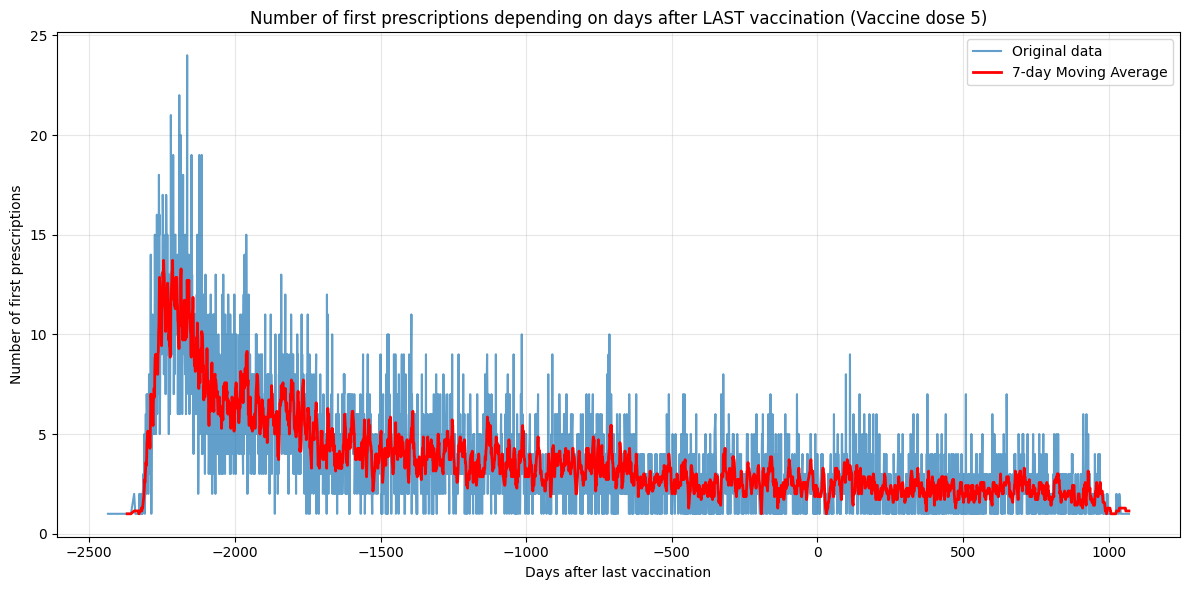

In [22]:
# === Number of first prescriptions depending on days after LAST vaccination (ONE BY ONE for each dose) ===

for vaccine_amount, indexes_map in first_pr_map_vax_segregation.items():
    draw_chart(
        indexes_map,
        "Days after last vaccination",
        "Number of first prescriptions",
        f"Number of first prescriptions depending on days after LAST vaccination (Vaccine dose {vaccine_amount})",
    )

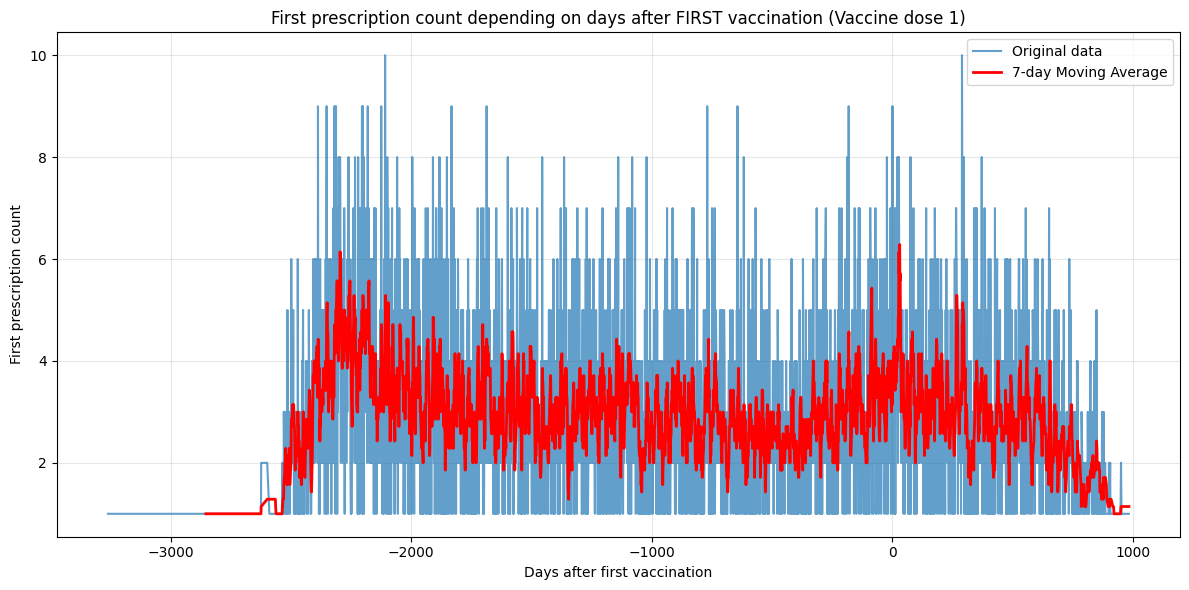

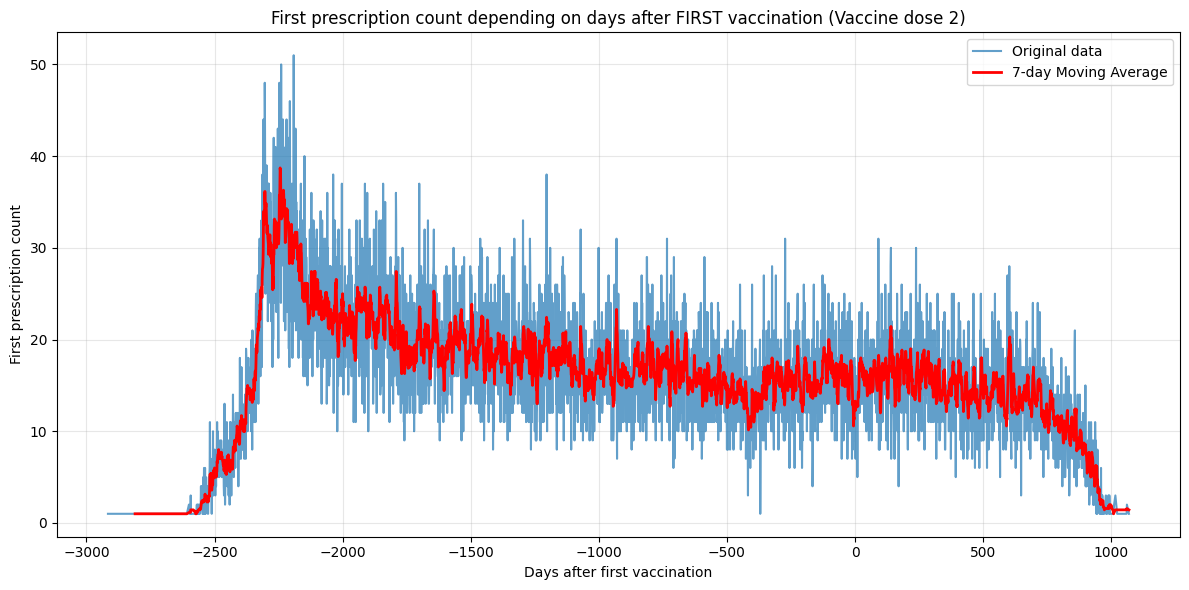

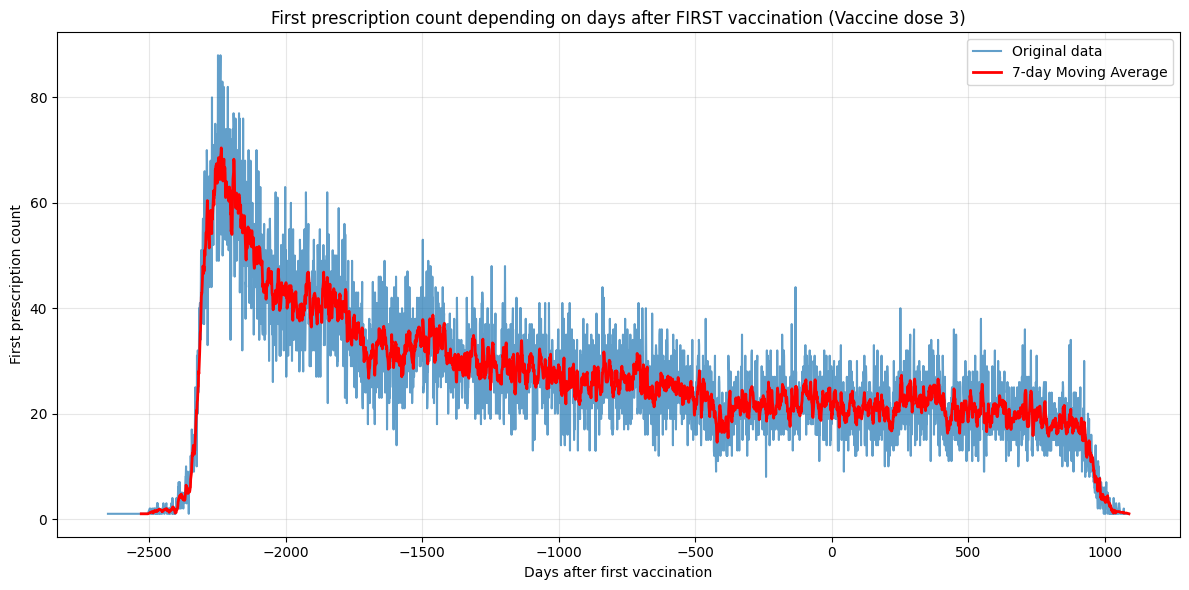

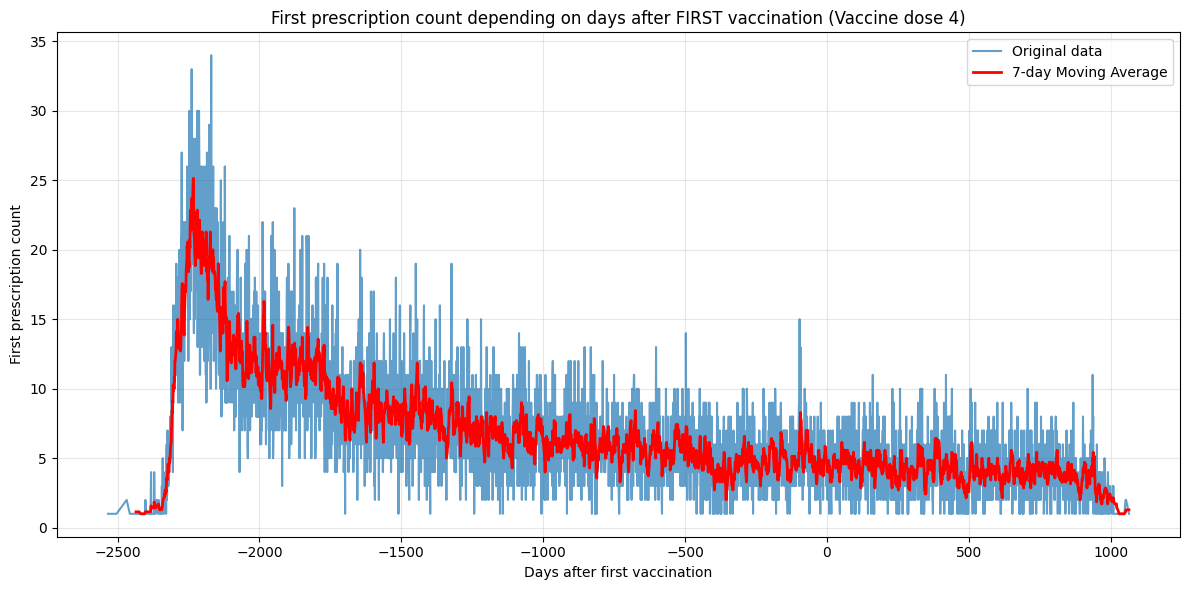

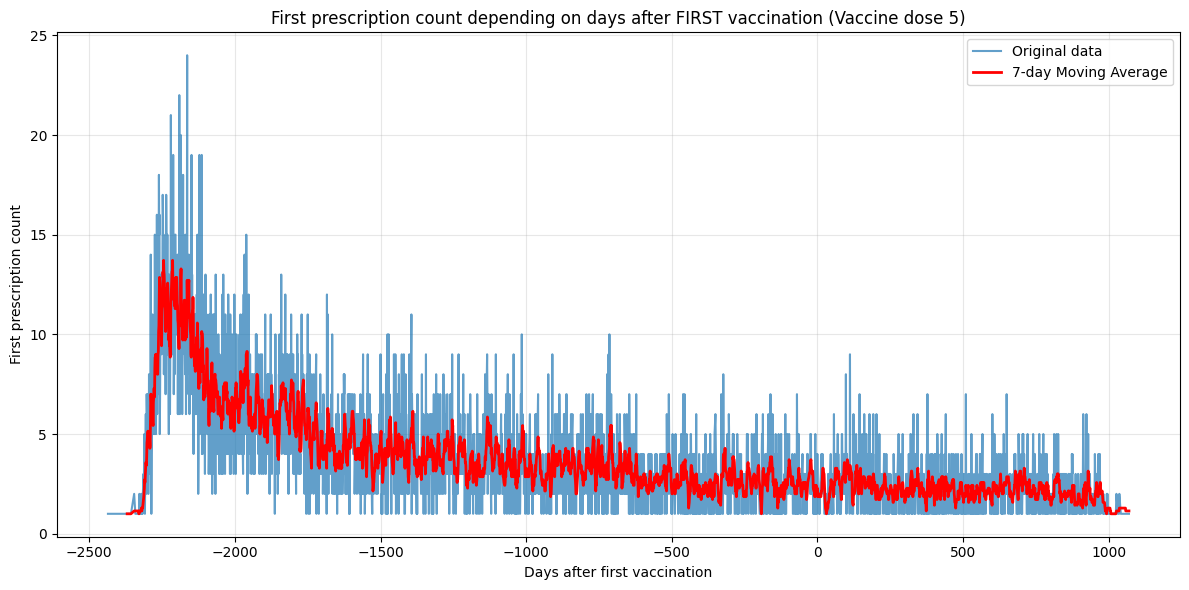

In [23]:
# === Number of first prescriptions depending on days after FIRST vaccination (ONE BY ONE for each dose) ===

for vaccine_amount, indexes_map in first_pr_from_first_dose_map.items():
    draw_chart(
        indexes_map,
        "Days after first vaccination",
        "First prescription count",
        f"First prescription count depending on days after FIRST vaccination (Vaccine dose {vaccine_amount})",
    )

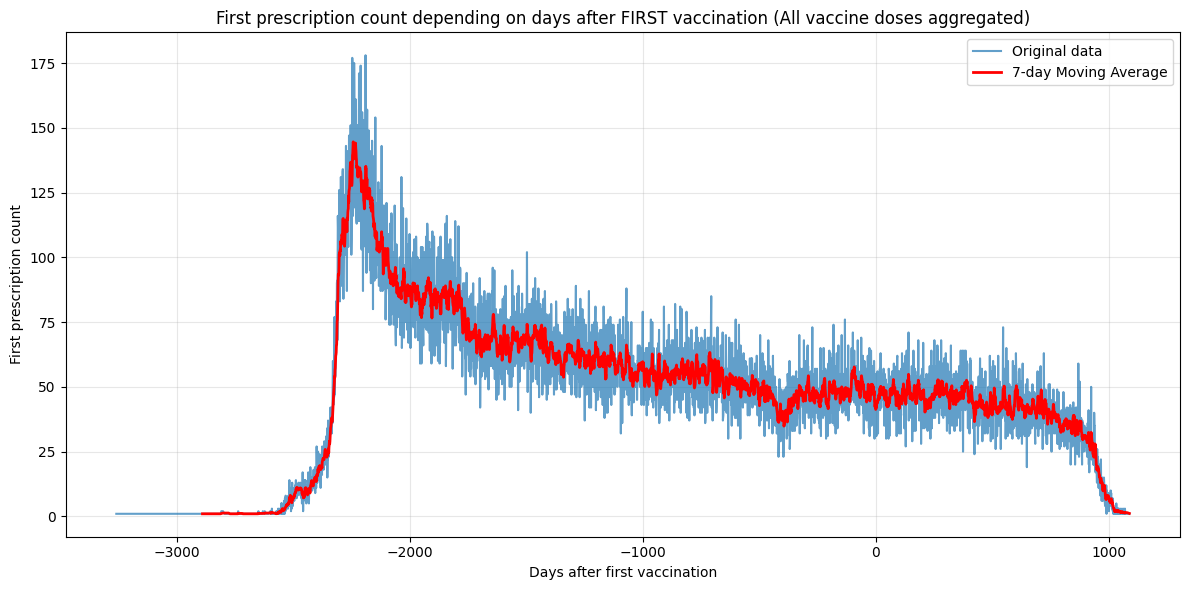

In [24]:
# === Number of first prescriptions depending on days after FIRST vaccination (ALL DOSES AGGREGATED) ===

draw_chart(
    first_pr_map_no_vax_segregation,
    "Days after first vaccination",
    "First prescription count",
    "First prescription count depending on days after FIRST vaccination (All vaccine doses aggregated)",
)

{921: 4, 313: 17, 22: 46, 1057: 40, 579: 22, 910: 31, 1252: 31, 705: 39, 616: 32, 65: 20, 57: 34, 1319: 7, 709: 34, 1295: 20, 77: 22, 920: 6, 460: 3, 968: 13, 1453: 8, 1446: 6, 1247: 29, 792: 23, 1303: 15, 1199: 25, 163: 15, 649: 38, 638: 37, 1037: 32, 540: 23, 491: 28, 1046: 9, 454: 26, 1258: 33, 1297: 19, 740: 21, 449: 23, 799: 26, 1267: 23, 21: 30, 170: 15, 1003: 26, 1246: 23, 308: 17, 677: 32, 196: 19, 450: 14, 250: 24, 1084: 46, 780: 6, 68: 38, 498: 21, 125: 9, 628: 36, 310: 17, 1398: 36, 1251: 38, 1115: 27, 34: 45, 62: 24, 317: 22, 1437: 30, 14: 32, 996: 21, 1087: 29, 1017: 35, 275: 18, 1142: 37, 427: 26, 1360: 28, 650: 38, 1231: 21, 526: 13, 961: 21, 56: 32, 812: 26, 691: 33, 617: 22, 522: 6, 1175: 39, 953: 28, 1351: 34, 952: 22, 1230: 29, 294: 28, 1188: 26, 239: 14, 931: 19, 674: 46, 745: 5, 589: 18, 420: 19, 964: 24, 16: 30, 1405: 29, 581: 16, 1071: 49, 728: 16, 516: 23, 887: 27, 611: 23, 660: 36, 1015: 38, 568: 19, 1209: 29, 1272: 27, 475: 24, 392: 15, 895: 36, 7: 24, 1450: 3

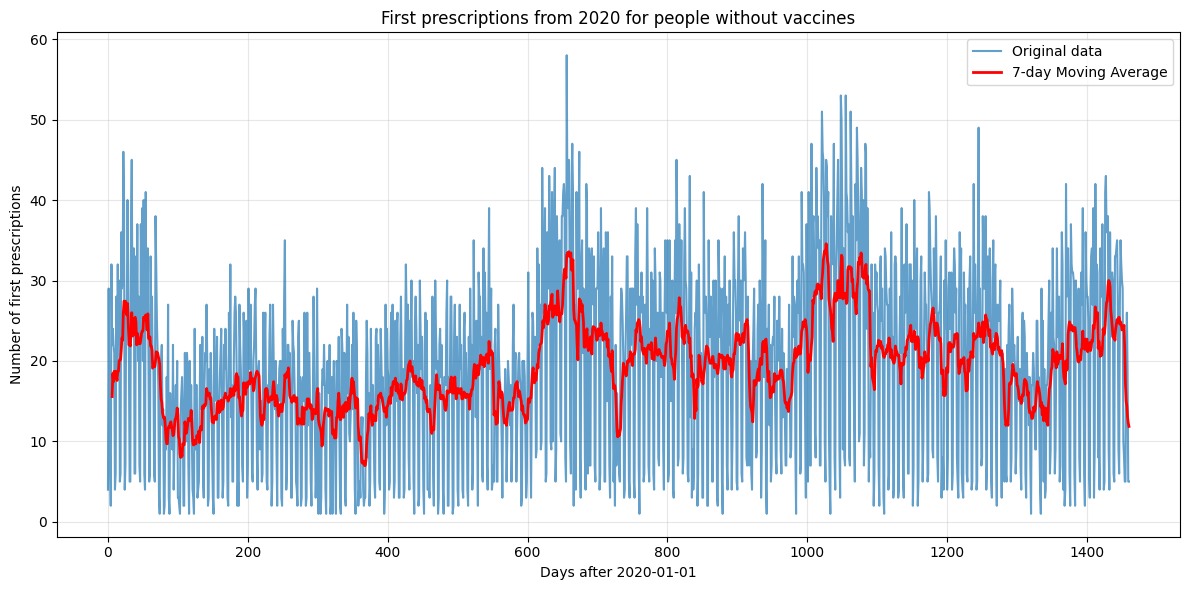

In [25]:
from_date = datetime(2020, 1, 1).date()
first_pr_from_2020 = {}

for p in persons:
    first_prescription_date = p.prescriptions[0].date if p.prescriptions else None
    if first_prescription_date and not p.vaccines:
        if first_prescription_date < from_date:
            continue

        days_after_first_prescription = (first_prescription_date - from_date).days
        if days_after_first_prescription not in first_pr_from_2020:
            first_pr_from_2020[days_after_first_prescription] = 1
        else:
            first_pr_from_2020[days_after_first_prescription] += 1

print(first_pr_from_2020)

draw_chart(
    mapp=first_pr_from_2020,
    x_label="Days after 2020-01-01",
    y_label="Number of first prescriptions",
    title="First prescriptions from 2020 for people without vaccines",
)